[0.86956522 0.13043478]


<ipython-input-1-c81a462cbb7a>:179: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 1d, A), array(float64, 1d, C))
  m1 = m1 + np.dot(mu0[:,ie],knotsb)


[1, 0.19196644558644826, 0.11505230322878517, 0.13940080614044945]
[2, 0.17906266998543852, 0.11529578825790181, 0.13790479669243233]
[3, 0.16639151339983949, 0.11552187834224711, 0.1364354280744758]
[4, 0.15368078950035047, 0.11573101383956941, 0.13495608668519563]
[5, 0.14277638139239057, 0.11592326456802567, 0.1337142207072347]
[6, 0.13126423531889708, 0.11610117412941776, 0.13238657446752314]
[7, 0.12164036364141317, 0.1162640281327988, 0.13130253301544298]
[8, 0.11157448395796976, 0.11641441318162524, 0.1301556232175404]
[9, 0.10234771755971339, 0.11655182528198438, 0.12911245177922534]
[10, 0.09375776192465546, 0.1166774315469568, 0.12814608393369434]
[11, 0.08637307981393949, 0.11679211807082418, 0.12732828412207586]
[12, 0.07822686405338652, 0.1168974797313367, 0.12640918852714572]
[13, 0.07147181880570352, 0.11699259681929479, 0.1256603304331991]
[14, 0.06470508085683413, 0.11707927415543383, 0.1249053615686119]
[15, 0.05877824258887587, 0.11715753502956561, 0.1242502559551061

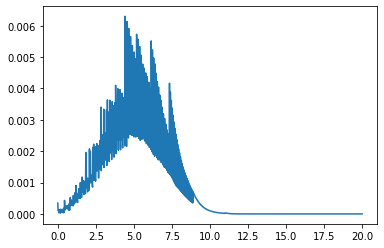

In [1]:
# Bewley-Aiyagari model
# May 2020, Takeki Sunakawa
from numba import njit
import numpy as np
import matplotlib.pyplot as plt
import time

β  = 0.96
α  = 0.36 
δ  = 1-0.92
σ  = 1.5
μ  = 0.05
pee = 0.925
puu = 0.5

# grid points
ne = 2
Ge = np.array([1.0,μ]) 
Pe = np.array([[pee,1-pee],
    [1-puu,puu]]) 

nb = 1001
kmin = 0
kmax = 20.0
#kbounds = np.array([kmin,kmax])
knotsb = np.linspace(kmin,kmax,nb)

mue = np.identity(ne)
for i in range(10000):
    mue = Pe@mue
    
mue = mue[0,:]
print(mue)
znow = 1.0
# efficiency unit of labor
lnow = Ge.T@mue

# initial distribution
vmat0 = np.zeros((nb,ne))
mu0   = np.ones((nb,ne))/(nb*ne)

# initial value of r
mnow = lnow*(α*β/(1.0-β*(1.0-δ)))**(1.0/(1.0-α))
mnow = 5.2074 # from My_Aiyagari.m
m0 = mnow
r0 = (α)*znow*mnow**(α-1)*lnow**(1-α);


@njit
def gridlookup2(x0,xgrid):

    nx = np.shape(xgrid)[0]

    ix = 0
    for jx in range(nx):
        if x0<=xgrid[jx]:
            break
        ix = ix+1

#     ix = np.min(np.max(1,ix),nx-1)
    ix = min(max(1,ix),nx-1)

    return ix-1

@njit
def driver(r0,vmat0,mu0,Ge,Pe,knotsb,β,α,δ,znow,lnow,critin,critmu):

    vmat1 = np.zeros((nb,ne))
    gmat0 = np.zeros((nb,ne))

    # Factor Price
    m0 = lnow*(r0/α/znow)**(1/(α-1))
    #r0 = (ALPHA)*znow*m0^(ALPHA-1)*lnow^(1-ALPHA); 
    w0 = (1-α)*znow*m0**(α)*lnow**(-α)

    # instanteneous utility
    umat0 = np.zeros((nb,nb,ne))
    for ie in range(ne):
        for ib in range(nb):
            for jb in range(nb):

                enow = Ge[ie]
                know = knotsb[ib]
                kp   = knotsb[jb]
                cnow = w0*enow + (1.0+r0-δ)*know - kp;

                if cnow>0:
                    umat0[jb,ib,ie] = np.log(cnow)
                else:
                    umat0[jb,ib,ie] = -1e+10

    # value function iteration
    diff   = 1e+4
    iterin = 0

    while diff>critin:

        # NOTE: np.max with axis argument is not supported by numba
#         for ie in range(ne):

#             utemp = umat0[:,:,ie]
#             vcond = Pe[ie,0]*vmat0[:,0] + Pe[ie,1]*vmat0[:,1]
#             vtemp = utemp + β*vcond.reshape(nb,1) # BUG: vcond should have been (nbx1)
#             vmat1[:,ie] = np.max(vtemp,axis=0)

        for ie in range(ne):

            for ib in range(nb):

                utemp = umat0[:,ib,ie]
                vcond = Pe[ie,0]*vmat0[:,0] + Pe[ie,1]*vmat0[:,1]
                vtemp = utemp + β*vcond
                vmat1[ib,ie] = np.max(vtemp)

        diff = np.max(np.abs(vmat1-vmat0))
        iterin = iterin+1
        vmat0 = np.copy(vmat1)
#         print([iterin,diff])

    # policy function
    for ie in range(ne):

        for ib in range(nb):

            utemp = umat0[:,ib,ie]
            vcond = Pe[ie,0]*vmat0[:,0] + Pe[ie,1]*vmat0[:,1]
            vtemp = utemp + β*vcond
            jb = np.argmax(vtemp)
            gmat0[ib,ie] = knotsb[jb] 

    # transition matrix
    AA = np.zeros((nb*ne,nb*ne))
#     kb = np.zeros((nb,ne),dtype=int) # NOTE: it may prevent the use of numba
    wb = np.zeros((nb,ne))

    for ie in range(ne):

        for ib in range(nb):

            know = knotsb[ib]
            kp = gmat0[ib,ie]
#             kb[ib,ie] = gridlookup2(kp,knotsb)
            kb = gridlookup2(kp,knotsb)
#             wb[ib,ie] = (knotsb[kb[ib,ie]+1]-kp)/(knotsb[kb[ib,ie]+1]-knotsb[kb[ib,ie]])
            wb[ib,ie] = (knotsb[kb+1]-kp)/(knotsb[kb+1]-knotsb[kb])

            for je in range(ne):

                ia = nb*ie+ib
#                 ja = nb*je+kb[ib,ie]
                ja = nb*je+kb
                AA[ia,ja]   = wb[ib,ie]*Pe[ie,je]
                AA[ia,ja+1] = (1.0-wb[ib,ie])*Pe[ie,je]

    # distribution
    diffmu = 1e+4
    dist   = np.zeros(2*nb)
    mu1    = np.zeros((nb,ne))

    while diffmu>critmu:

        dist[0:nb]    = mu0[:,0]
        dist[nb:2*nb] = mu0[:,1]
#         dist = np.reshape(mu0,(2*nb,1),order='F') # NOTE: cannot use with numba
        dist = AA.T@dist
        mu1[:,0] = dist[0:nb]
        mu1[:,1] = dist[nb:2*nb]
#         mu1  = np.reshape(dist,(nb,2),order='F')

        diffmu = np.max(np.abs(mu1-mu0))
    #     print(diffmu)
        mu0  = mu1/np.sum(mu1)
        
    # Calculate K
    m1 = 0.0
    for ie in range(ne):

#         m1 = m1 + mu0[:,ie].T@knotsb
        m1 = m1 + np.dot(mu0[:,ie],knotsb)

    r1 = (α)*znow*m1**(α-1)*lnow**(1-α)
        
    return r1, vmat0, mu0


start = time.time()
critin  = 1e-4
critmu  = 1e-8
critout = 1e-3
diffout = 1e+3
damp = 0.01
iter = 0

# for test
# r1,vmat0,mu0 = driver(r0,vmat0,mu0,Ge,Pe,knotsb,β,α,δ,znow,lnow,critin,critmu)

while diffout>critout:

    r1,vmat0,mu0 = driver(r0,vmat0,mu0,Ge,Pe,knotsb,β,α,δ,znow,lnow,critin,critmu)

    diffout = np.abs(np.log(r1)-np.log(r0))
    iter = iter+1
    print([iter,diffout,r0,r1]);

    # Update K
    r0 = damp*r1 + (1.0-damp)*r0

eptime = time.time()-start
print(eptime)

plt.plot(knotsb,mu0[:,0])